# Gaussian Process Model Selection

This demo contrasts two methods for model selection:
1. Full Bayesian inference over kernel/likelihood hyperparameters
2. Using only the MLE estimates of the kernel/likelihood hyperparameters

<a target="_blank" href="https://colab.research.google.com/github/gpleiss/gp_bo_demos/blob/main/kernel_demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import math
import torch
from matplotlib import pyplot as plt


# Maybe install requirements
try:
    import gpytorch
except ImportError:
    %pip install gpytorch
    import gpytorch
    
try:
    import pyro
except ImportError:
    %pip install pyro-ppl
    import pyro
    
try:
    import tqdm.notebook as tqdm
except ImportError:
    %pip install tqdm
    import tqdm.notebook as tqdm
    
from pyro.infer.mcmc import NUTS, MCMC, HMC
from gpytorch.priors import LogNormalPrior, NormalPrior, UniformPrior

%matplotlib inline

In [2]:
# Training data is 11 points in [0,1] inclusive regularly spaced
train_x = torch.rand(8)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2

#Test inputs
test_x = torch.linspace(-1, 2, 101).unsqueeze(-1)

## Model

**Mean**: 0-mean

**Kernel**: Matern 5/2

**Parameters to infer:**
- $\ell \sim \mathcal{U}[0.01, 0.5]$ - kernel lengthscale
- $o \sim \mathcal{U}[1, 2]$ - kernel outputscale
- $\sigma_\mathrm{obs} \sim \mathcal{U}[0.01, 0.5]$ - likelihood observational noise

In [3]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, use_priors=True):
        likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.Positive())
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5))
        if use_priors:
            self.covar_module.base_kernel.register_prior("lengthscale_prior", UniformPrior(0.01, 0.5), "lengthscale")
            self.covar_module.register_prior("outputscale_prior", UniformPrior(1, 2), "outputscale")
            self.likelihood.register_prior("noise_prior", UniformPrior(0.01, 0.5), "noise")
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

## Full Bayesian Inference

Obtain $p(\ell, o, \sigma_\mathrm{obs} \mid \mathcal D)$, as well as

$$
    p(f(\cdot) \mid \mathcal D) = 
    \int p(f(\cdot) \mid \ell, o, \sigma_\mathrm{obs}, \mathcal D) \:
    p(\ell, o, \sigma_\mathrm{obs} \mid \mathcal D) \:
    \mathrm{d}\ell \: \mathrm{d}o \: \mathrm{d}\sigma_\mathrm{obs}
$$

Note that we can no longer perform exact inference, and so we must resort to MCMC

In [4]:
fully_bayesian_model = ExactGPModel(train_x, train_y)


def pyro_model(x, y):
    with gpytorch.settings.fast_computations(False, False, False):
        sampled_model = fully_bayesian_model.pyro_sample_from_prior()
        output = sampled_model.likelihood(sampled_model(x))
        pyro.sample("obs", output, obs=y)
    return y


nuts_kernel = NUTS(pyro_model)
mcmc_run = MCMC(nuts_kernel, num_samples=20, warmup_steps=50)
mcmc_run.run(train_x, train_y)

fully_bayesian_model.eval()
fully_bayesian_model.pyro_load_from_samples(mcmc_run.get_samples())
with torch.no_grad():
    fully_bayesian_output = fully_bayesian_model(test_x)
    fully_bayesian_samples = fully_bayesian_output.sample(torch.Size([5])).view(-1, len(test_x))

Sample: 100%|████████████████████████████████████████████| 70/70 [00:04, 15.29it/s, step size=4.05e-01, acc. prob=0.935]               
/Users/gpleiss/miniconda3/envs/playground/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


## Optimized Hyperparameters

Obtain MLE point estimates for $\ell, o, \sigma_\mathrm{obs}$.

Under this framework, $f(\cdot) \mid \mathcal D$ is really
$f(\cdot) \mid \mathcal D, \ell, o, \sigma_\mathrm{obs}$.

In [5]:
optimized_model = ExactGPModel(train_x, train_y, use_priors=False)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(optimized_model.likelihood, optimized_model)
optimizer = torch.optim.Adam(optimized_model.parameters(), lr=0.1)
iterator = tqdm.tqdm(range(50), desc="Optimizing")

optimized_model.train()
for _ in iterator:
    optimizer.zero_grad()
    output = optimized_model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    iterator.set_postfix(
        l=optimized_model.covar_module.base_kernel.lengthscale.item(),
        o=optimized_model.covar_module.outputscale.item(),
        sigma=optimized_model.likelihood.noise.item(),
    )

optimized_model.eval()
with torch.no_grad():
    optimized_output = optimized_model(test_x)
    optimized_samples = optimized_output.sample(torch.Size([100]))

Optimizing:   0%|          | 0/50 [00:00<?, ?it/s]

## Comparison

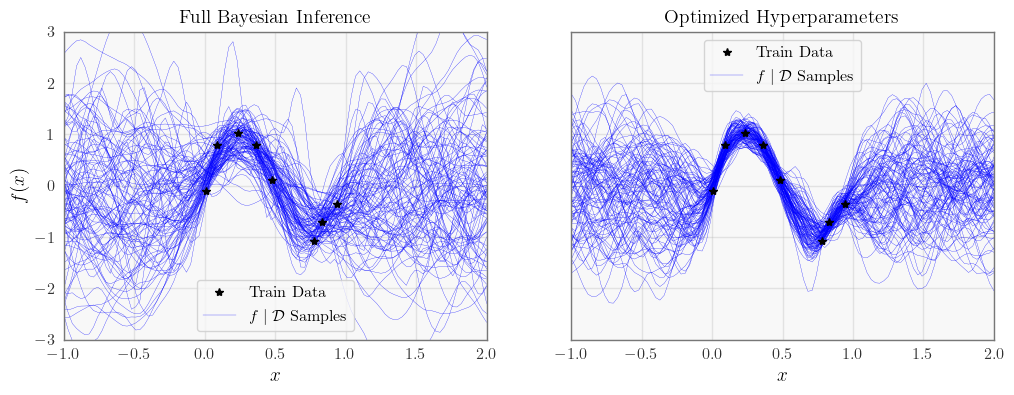

In [6]:
f, (fully_bayesian_ax, optimized_ax) = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
    
fully_bayesian_ax.plot(train_x.numpy(), train_y.numpy(), "k*", zorder=10, label="Train Data")
fully_bayesian_ax.plot(
    test_x.numpy(), fully_bayesian_samples[0].numpy(), "b",
    linewidth=0.2, label=r"$f \mid \mathcal D$ Samples"
)
fully_bayesian_ax.plot(
    test_x.numpy(), fully_bayesian_samples[1:].T.numpy(), "b",
    linewidth=0.2
)
fully_bayesian_ax.set(xlim=[-1, 2], ylim=[-3, 3], ylabel="$f(x)$", xlabel="$x$", title="Full Bayesian Inference")
fully_bayesian_ax.legend(loc="best")

optimized_ax.plot(train_x.numpy(), train_y.numpy(), "k*", zorder=10, label="Train Data")
optimized_ax.plot(
    test_x.numpy(), optimized_samples[0].numpy(), "b",
    linewidth=0.2, label=r"$f \mid \mathcal D$ Samples"
)
optimized_ax.plot(
    test_x.numpy(), optimized_samples[1:].T.numpy(), "b",
    linewidth=0.2
)
optimized_ax.set(xlim=[-1, 2], ylim=[-3, 3], xlabel="$x$", title="Optimized Hyperparameters")
optimized_ax.legend(loc="best")